In [1]:
import pandas as pd
import numpy as np
import requests
import json
from bs4 import BeautifulSoup

---
## 1. a) Web Scraping to gather all boroughs and districts name in Jakarta

In [2]:
url = 'https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Daerah_Khusus_Ibukota_Jakarta'
hdrs = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}
try:
    response = requests.get(url=url,headers=hdrs)
    soup = BeautifulSoup(response.content,"html.parser")
except:
    print('An error occured.')

In [3]:
draft1, borough = soup.findAll('span', attrs={'class':'mw-headline'}), []
draft2, total_district = soup.findAll('p'), []
draft3, district, temp, index, pot = soup.findAll('tr',attrs={'valign':'top'}), [], '', 0, 1

# gather list of all boroughs
for i in draft1:
    if i.find('a') != None and 'kepulauan' not in i.find('a').text.lower():
        borough.append(i.find('a').text.strip().upper())

# gather list of total neighbourhoods of each borough
for i in draft2:
    if 'kepulauan' not in i.text.lower():
        for j in range(len(i.text.split())):
            if i.text.split()[j-1].lower() == 'memiliki' and i.text.split()[j+1].lower() =='kecamatan':
                total_district.append(int(i.text.split()[j]))

# gather list of all neighbourhoods of each borough
for i in draft3:
    if i.find('a') != None and 'kepulauan' not in i.find('a').text.lower():
        if pot < total_district[index]:
            temp += i.find('a').text.strip()+','
            pot += 1
        elif pot == total_district[index]:
            temp += i.find('a').text.strip()
            district.append(temp)
            temp,pot,index = '', 1, index+1

# join all data into a single dataset
jakarta_dataset = pd.DataFrame({'borough':borough,'number_of_neighbourhoods':total_district,'neighbourhoods':district})
display(jakarta_dataset)

borough  number_of_neighbourhoods  \
0    KOTA ADMINISTRASI JAKARTA PUSAT                         8   
1    KOTA ADMINISTRASI JAKARTA UTARA                         6   
2    KOTA ADMINISTRASI JAKARTA TIMUR                        10   
3  KOTA ADMINISTRASI JAKARTA SELATAN                        10   
4    KOTA ADMINISTRASI JAKARTA BARAT                         8   

                                      neighbourhoods  
0  Cempaka Putih,Gambir,Johar Baru,Kemayoran,Ment...  
1  Cilincing,Kelapa Gading,Koja,Pademangan,Penjar...  
2  Cakung,Cipayung,Ciracas,Duren Sawit,Jatinegara...  
3  Cilandak,Jagakarsa,Kebayoran Baru,Kebayoran La...  
4  Cengkareng,Grogol Petamburan,Taman Sari,Tambor...

## 1. b) Find all neighbourhoods' geolocation (latitude & longitude) including postal code from JSON and CSV files

In [4]:
try:
    with open('Data/GeoLocation_Indonesia/31/31.json') as f:
        json31 = json.load(f)
except:
    print('An error occured.')

borough_code = []
for i in json31['children']:
    borough_code.append(i)
borough_code.pop(0)

df_districts = pd.read_csv('Data/GeoLocation_Indonesia/subDistricts.csv')

df_districts = df_districts[df_districts['Parent'].apply(lambda x : x in borough_code)][['Name','Latitude','Longitude','Postal']].reset_index(drop=True)
df_districts['Name'] = df_districts['Name'].apply(lambda x : x.upper())
df_districts = df_districts.rename(columns={'Name':'neighbourhoods'})
display(df_districts.head())

neighbourhoods  Latitude   Longitude                         Postal
0       JAGAKARSA -6.330417  106.825463  12530,12610,12620,12630,12640
1    PASAR MINGGU -6.292043  106.830826  12510,12520,12540,12550,12560
2        CILANDAK -6.289802  106.790352  12410,12420,12430,12440,12450
3    PESANGGRAHAN -6.254297  106.755188  12250,12260,12270,12320,12330
4  KEBAYORAN LAMA -6.249321  106.780382  12210,12220,12230,12240,12310

In [5]:
col = list(jakarta_dataset.columns)
col.remove('number_of_neighbourhoods')
jakarta_ds = pd.DataFrame(columns=col)
for i,v in enumerate(jakarta_dataset.values):
    jakarta_ds = jakarta_ds.append(pd.DataFrame({col[0]:v[0], col[1]:v[2].upper().split(',')}), ignore_index=True)
jakarta = pd.merge(jakarta_ds, df_districts, how='inner', on='neighbourhoods')
display(jakarta.head())

borough neighbourhoods  Latitude   Longitude  \
0  KOTA ADMINISTRASI JAKARTA PUSAT  CEMPAKA PUTIH -6.181269  106.867074   
1  KOTA ADMINISTRASI JAKARTA PUSAT         GAMBIR -6.171504  106.817510   
2  KOTA ADMINISTRASI JAKARTA PUSAT     JOHAR BARU -6.183050  106.854320   
3  KOTA ADMINISTRASI JAKARTA PUSAT      KEMAYORAN -6.162770  106.859259   
4  KOTA ADMINISTRASI JAKARTA PUSAT        MENTENG -6.195169  106.838157   

                                Postal  
0                    10510,10520,10570  
1  10110,10120,10130,10140,10150,10160  
2              10530,10540,10550,10560  
3        10610,10620,10630,10640,10650  
4        10310,10320,10330,10340,10350

## 1. c) population number of each neighbourhood from CSV file

In [6]:
df_population = pd.read_csv('Data/JakartaData/Jumlah-Penduduk-Menurut-Kecamatan-dan-Jenis-Kelamin-2014.csv', header=0, names=['year','borough','neighbourhoods','gender','population(2014)'])
df_population['borough'] = df_population['borough'].apply(lambda x : 'KOTA ADMINISTRASI '+x.upper())
df_population['neighbourhoods'] = df_population['neighbourhoods'].apply(lambda x : x.upper())
df_population = df_population[df_population['borough'].apply(lambda x : x in set(jakarta['borough'].values))].groupby(['neighbourhoods','borough']).sum().reset_index()[['borough','neighbourhoods','population(2014)']].sort_values('borough',ignore_index=True)
display(df_population.head())

borough     neighbourhoods  population(2014)
0  KOTA ADMINISTRASI JAKARTA BARAT          KALIDERES            431296
1  KOTA ADMINISTRASI JAKARTA BARAT          KEMBANGAN            300802
2  KOTA ADMINISTRASI JAKARTA BARAT        KEBON JERUK            357788
3  KOTA ADMINISTRASI JAKARTA BARAT  GROGOL PETAMBURAN            232697
4  KOTA ADMINISTRASI JAKARTA BARAT         TAMAN SARI            110008

## 1. d) Finalize Jakarta's dataset that will be used

In [7]:
df_jakarta = pd.merge(jakarta, df_population[['neighbourhoods','population(2014)']], how='inner', on='neighbourhoods')
# df_jakarta.to_csv(r'Data\Jakarta_final.csv', index = False, header=True) # export data
display(df_jakarta.head())
print(('-'*100)+'\n', df_jakarta.isna().sum(), end='\n'+('-'*100)+'\n\n') # Check null value for our final Jakarta's dataset
display(df_jakarta.info()) # # Check the integrity of datatype in our dataset's features

borough neighbourhoods  Latitude   Longitude  \
0  KOTA ADMINISTRASI JAKARTA PUSAT  CEMPAKA PUTIH -6.181269  106.867074   
1  KOTA ADMINISTRASI JAKARTA PUSAT         GAMBIR -6.171504  106.817510   
2  KOTA ADMINISTRASI JAKARTA PUSAT     JOHAR BARU -6.183050  106.854320   
3  KOTA ADMINISTRASI JAKARTA PUSAT      KEMAYORAN -6.162770  106.859259   
4  KOTA ADMINISTRASI JAKARTA PUSAT        MENTENG -6.195169  106.838157   

                                Postal  population(2014)  
0                    10510,10520,10570             84864  
1  10110,10120,10130,10140,10150,10160             78152  
2              10530,10540,10550,10560            117440  
3        10610,10620,10630,10640,10650            220548  
4        10310,10320,10330,10340,10350             68079

----------------------------------------------------------------------------------------------------
 borough             0
neighbourhoods      0
Latitude            0
Longitude           0
Postal              0
population(2014)    0
dtype: int64
----------------------------------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 41
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   borough           42 non-null     object 
 1   neighbourhoods    42 non-null     object 
 2   Latitude          42 non-null     float64
 3   Longitude         42 non-null     float64
 4   Postal            42 non-null     object 
 5   population(2014)  42 non-null     int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 2.3+ KB


None

---

In [8]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
import geocoder

In [9]:
df_jakarta = pd.read_csv('Data/Jakarta_final.csv')
df_jakarta.head()
# # define a function to get coordinates
# def get_latlng(neighborhood):
#     lat_lng_coords = None
#     while(lat_lng_coords is None):
#         g = geocoder.arcgis('{}, Jakarta, Indonesia'.format(neighborhood))
#         lat_lng_coords = g.latlng
#     return lat_lng_coords
# coords = [ get_latlng(neighborhood) for neighborhood in df_jakarta["neighbourhoods"] ]

borough neighbourhoods  Latitude   Longitude  \
0  KOTA ADMINISTRASI JAKARTA PUSAT  CEMPAKA PUTIH -6.181269  106.867074   
1  KOTA ADMINISTRASI JAKARTA PUSAT         GAMBIR -6.171504  106.817510   
2  KOTA ADMINISTRASI JAKARTA PUSAT     JOHAR BARU -6.183050  106.854320   
3  KOTA ADMINISTRASI JAKARTA PUSAT      KEMAYORAN -6.162770  106.859259   
4  KOTA ADMINISTRASI JAKARTA PUSAT        MENTENG -6.195169  106.838157   

                                Postal  population(2014)  
0                    10510,10520,10570             84864  
1  10110,10120,10130,10140,10150,10160             78152  
2              10530,10540,10550,10560            117440  
3        10610,10620,10630,10640,10650            220548  
4        10310,10320,10330,10340,10350             68079

## 2. a) Get Geolocation Coordinate of Jakarta, Indonesia

In [10]:
loc = 'Jakarta, Indonesia'
geoloc = Nominatim(user_agent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36')
maps = geoloc.geocode(loc)
lat = maps.latitude
lon = maps.longitude
print(f'The coordinate of Jakarta, Indonesia : {lat}, {lon}')

The coordinate of Jakarta, Indonesia : -6.1753942, 106.827183


## 2. b) Create a Map of Jakarta with All Neighbourhoods

In [11]:
map_jakarta = folium.Map(location=[lat,lon], zoom_start=12)

for la, ln, bor, nei in zip(df_jakarta['Latitude'],df_jakarta['Longitude'],df_jakarta['borough'],df_jakarta['neighbourhoods']):
    label = folium.Popup(f'{nei}, {bor}', parse_html=True)
    folium.CircleMarker([la,ln], radius=10, popup=label, color='#00C600', fill=True, fill_color='00D800', fill_opacity=0.7, parse_html=False).add_to(map_jakarta)

map_jakarta

---

In [12]:
import pandas as pd
import requests
import json

## 3. a) Define Foursquare API credentials

In [13]:
CLIENT_ID = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxx' # Foursquare ID
CLIENT_SECRET = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' # Foursquare Secret
VERSION = 'xxxxxxxx' # Foursquare API version

## 3. b) Define a function to execute Foursquare API (https://api.foursquare.com/v2/venues/search)

In [14]:
def getTopPopularRestaurants(bor, names, latitudes, longitudes, category_id, radius=500, limit=100):
    
    venues_list=[]
    for b, name, lat, lng in zip(bor, names, latitudes, longitudes):
        print('fetching restaurants in',name+'\'s area')
        url = f'https://api.foursquare.com/v2/venues/search?\
        &client_id={CLIENT_ID}\
        &client_secret={CLIENT_SECRET}\
        &v={VERSION}\
        &ll={lat},{lng}\
        &categoryId={category_id}\
        &radius={radius}\
        &limit={limit}\
        &sortByPopularity=True'
        hdrs = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}

        try:
            resp = requests.get(url,headers=hdrs)
            results = resp.json()["response"]['venues']
        except:
            print('An error occured.')
        
        venues_list.append([(b, name, lat, lng, v['name'], v['location']['lat'], v['location']['lng'], v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 'Neighborhood', 'Neighborhood_Latitude', 'Neighborhood_Longitude', 'Venue', 'Venue_Latitude', 'Venue_Longitude', 'Venue_Category']
    
    return(nearby_venues)

## 3. c) Use the Foursquare API to explore most popular restaurants near Jakarta neighborhoods

In [15]:
# https://developer.foursquare.com/docs/build-with-foursquare/categories/ as source
# import food category id dataset
food_cat_id = pd.read_csv('Data/foursquare_FoodCategory.csv')
food_cat_id.drop(index=[25], axis=0, inplace=True)
food_cat_id.reset_index(drop=True, inplace=True)
display(food_cat_id)

food_category                        id
0              American  4bf58dd8d48988d14e941735
1            Australian  4bf58dd8d48988d169941735
2      Eastern European  4bf58dd8d48988d109941735
3               English  52e81612bcbc57f1066b7a05
4                French  4bf58dd8d48988d10c941735
5                 Halal  52e81612bcbc57f1066b79ff
6                Indian  4bf58dd8d48988d10f941735
7        Latin American  4bf58dd8d48988d1be941735
8               Mexican  4bf58dd8d48988d1c1941735
9               Burrito  4bf58dd8d48988d153941735
10                 Taco  4bf58dd8d48988d151941735
11       Middle Eastern  4bf58dd8d48988d115941735
12             Egyptian  5bae9231bedf3950379f89e1
13                Iraqi  5bae9231bedf3950379f89e7
14              Israeli  56aa371be4b08b9a8d573529
15              Kurdish  5744ccdfe4b0c0459246b4ca
16             Lebanese  58daa1558bbb0b01f18ec1cd
17              Persian  52e81612bcbc57f1066b79f7
18      Modern European  52e81612bcbc57f1066b79f9
19              Seafood  4bf58dd8d48988d1ce941735
20              Spanish  4bf58dd8d48988d150941735
21           Sri Lankan  5413605de4b0ae91d18581a9
22              Chinese  4bf58dd8d48988d145941735
23              Dim Sum  4bf58dd8d48988d1f5931735
24             Szechuan  52af3b773cf9994f4e043c03
25             Acehnese  52960eda3cf9994f4e043ac9
26             Balinese  52960eda3cf9994f4e043acb
27           Betawinese  52960eda3cf9994f4e043aca
28  Indonesian Meatball  52960eda3cf9994f4e043acc
29             Javanese  52960eda3cf9994f4e043ac7
30           Manadonese  52960eda3cf9994f4e043ac8
31           Padangnese  52960eda3cf9994f4e043ac5
32            Sundanese  52960eda3cf9994f4e043ac6
33             Japanese  4bf58dd8d48988d111941735
34       Japanese Curry  55a59bace4b013909087cb30
35                Ramen  55a59bace4b013909087cb24
36          Shabu-Shabu  55a59bace4b013909087cb15
37                 Soba  55a59bace4b013909087cb27
38                Sushi  4bf58dd8d48988d1d2941735
39                 Udon  55a59bace4b013909087cb2a
40               Korean  4bf58dd8d48988d113941735
41                Malay  4bf58dd8d48988d156941735
42         Noodle House  4bf58dd8d48988d1d1941735
43                Satay  56aa371be4b08b9a8d57350e
44                 Thai  4bf58dd8d48988d149941735
45               Bistro  52e81612bcbc57f1066b79f1
46               Buffet  52e81612bcbc57f1066b79f4
47             Dumpling  4bf58dd8d48988d108941735
48       Indian Chinese  54135bf5e4b08f3d2429dfdf
49         North Indian  54135bf5e4b08f3d2429dfdd
50         South Indian  54135bf5e4b08f3d2429dfde
51              Italian  4bf58dd8d48988d110941735
52                Kebab  5283c7b4e4b094cb91ec88d7
53            Pakistani  52e81612bcbc57f1066b79f8
54                Pizza  4bf58dd8d48988d1ca941735
55           Steakhouse  4bf58dd8d48988d1cc941735
56           Vegetarian  4bf58dd8d48988d1d3941735

In [16]:
jakarta_restaurants = getTopPopularRestaurants(bor = df_jakarta['borough'],
                                                names=df_jakarta['neighbourhoods'],
                                                latitudes=df_jakarta['Latitude'],
                                                longitudes=df_jakarta['Longitude'],
                                                category_id=','.join(food_cat_id['id'].values),
                                                radius=3000, limit=200
                                                )

fetching restaurants in CEMPAKA PUTIH's area
fetching restaurants in GAMBIR's area
fetching restaurants in JOHAR BARU's area
fetching restaurants in KEMAYORAN's area
fetching restaurants in MENTENG's area
fetching restaurants in SAWAH BESAR's area
fetching restaurants in SENEN's area
fetching restaurants in TANAH ABANG's area
fetching restaurants in CILINCING's area
fetching restaurants in KELAPA GADING's area
fetching restaurants in KOJA's area
fetching restaurants in PADEMANGAN's area
fetching restaurants in PENJARINGAN's area
fetching restaurants in TANJUNG PRIOK's area
fetching restaurants in CAKUNG's area
fetching restaurants in CIPAYUNG's area
fetching restaurants in CIRACAS's area
fetching restaurants in DUREN SAWIT's area
fetching restaurants in JATINEGARA's area
fetching restaurants in KRAMAT JATI's area
fetching restaurants in MAKASAR's area
fetching restaurants in MATRAMAN's area
fetching restaurants in PASAR REBO's area
fetching restaurants in PULO GADUNG's area
fetching re

## 3. d) Remove unwanted categories from Jakarta's restaurant dataset

In [19]:
banned_category = ['Farm','Hotel','Bakery','Ice Cream Shop','Bakery','Lounge''Grocery Store','Bar','Concert Hall','Convenience Store','Movie Theater','Poke Place','Residential Building (Apartment / Condo)']

jakarta_restaurants = jakarta_restaurants[ jakarta_restaurants['Venue_Category'].apply(lambda x : x not in banned_category) ]
jakarta_restaurants = jakarta_restaurants.reset_index(drop=True)
display(jakarta_restaurants)

Borough   Neighborhood  Neighborhood_Latitude  \
0     KOTA ADMINISTRASI JAKARTA PUSAT  CEMPAKA PUTIH              -6.181269   
1     KOTA ADMINISTRASI JAKARTA PUSAT  CEMPAKA PUTIH              -6.181269   
2     KOTA ADMINISTRASI JAKARTA PUSAT  CEMPAKA PUTIH              -6.181269   
3     KOTA ADMINISTRASI JAKARTA PUSAT  CEMPAKA PUTIH              -6.181269   
4     KOTA ADMINISTRASI JAKARTA PUSAT  CEMPAKA PUTIH              -6.181269   
...                               ...            ...                    ...   
2044  KOTA ADMINISTRASI JAKARTA BARAT      KEMBANGAN              -6.191140   
2045  KOTA ADMINISTRASI JAKARTA BARAT      KEMBANGAN              -6.191140   
2046  KOTA ADMINISTRASI JAKARTA BARAT      KEMBANGAN              -6.191140   
2047  KOTA ADMINISTRASI JAKARTA BARAT      KEMBANGAN              -6.191140   
2048  KOTA ADMINISTRASI JAKARTA BARAT      KEMBANGAN              -6.191140   

      Neighborhood_Longitude                       Venue  Venue_Latitude  \
0                 106.867074             Bakso Ciat Solo       -6.184014   
1                 106.867074             Asinan Ny. Isye       -6.201596   
2                 106.867074        Tahu Campur Lamongan       -6.195717   
3                 106.867074  Bakwan Bakso Malang Sutomo       -6.202069   
4                 106.867074                   Pagi Sore       -6.176376   
...                      ...                         ...             ...   
2044              106.741305                   Bakso Aan       -6.193553   
2045              106.741305                   Chuan Tin       -6.187765   
2046              106.741305                 Genki Sushi       -6.187277   
2047              106.741305                         A&W       -6.197390   
2048              106.741305             Eastern Kopi TM       -6.196146   

      Venue_Longitude                 Venue_Category  
0          106.866700      Indonesian Meatball Place  
1          106.884447  Vegetarian / Vegan Restaurant  
2          106.891073            Javanese Restaurant  
3          106.879130      Indonesian Meatball Place  
4          106.871474          Padangnese Restaurant  
...               ...                            ...  
2044       106.755545      Indonesian Meatball Place  
2045       106.755318             Chinese Restaurant  
2046       106.739535               Sushi Restaurant  
2047       106.751409            American Restaurant  
2048       106.755336               Asian Restaurant  

[2049 rows x 8 columns]

## 3. e) Final check for Jakarta's restaurant dataset

In [20]:
# Check null value in the dataset
jakarta_restaurants.isna().sum()

Borough                   0
Neighborhood              0
Neighborhood_Latitude     0
Neighborhood_Longitude    0
Venue                     0
Venue_Latitude            0
Venue_Longitude           0
Venue_Category            0
dtype: int64

In [21]:
# Check how many restaurants for each category in every neighborhood
jakarta_restaurants.groupby(['Neighborhood','Venue_Category']).count()['Venue'].head(50)

Neighborhood   Venue_Category               
CAKUNG         American Restaurant               5
               Betawinese Restaurant             1
               Chinese Restaurant                6
               Dim Sum Restaurant                1
               Dumpling Restaurant               1
               Fast Food Restaurant              1
               Halal Restaurant                  1
               Indian Restaurant                 2
               Indonesian Meatball Place         4
               Japanese Restaurant               3
               Javanese Restaurant               2
               Kebab Restaurant                  1
               Korean Restaurant                 1
               Noodle House                     13
               Pizza Place                       4
               Seafood Restaurant                1
CEMPAKA PUTIH  Argentinian Restaurant            1
               Asian Restaurant                  1
               Balinese Restaurant   

In [22]:
print('There are {} different categories in jakarta_restaurants\' dataset'.format(len(jakarta_restaurants['Venue_Category'].unique())))
print('There are {} restaurants found in Jakarta area'.format(len(jakarta_restaurants)))

There are 68 different categories in jakarta_restaurants' dataset
There are 2049 restaurants found in Jakarta area


In [23]:
jakarta_restaurants.to_csv(r'Data\Jakarta_restaurants.csv', index = False, header=True)

## 3. f) Visualize all restaurants in Jakarta area

In [24]:
map_jakarta = folium.Map(location=[lat,lon], zoom_start=12)

# Central point of each neighborhood with green circle
for la, ln, bor, nei in zip(df_jakarta['Latitude'],df_jakarta['Longitude'],df_jakarta['borough'],df_jakarta['neighbourhoods']):
    label = folium.Popup(f'{nei}, {bor}', parse_html=True)
    folium.CircleMarker([la,ln], radius=10, popup=label, color='#00C600', fill=True, fill_color='00D800', fill_opacity=0.7, parse_html=False).add_to(map_jakarta)

# location of all restaurants from the dataset mapped with geolocation (gold circle)
for la, ln, ven, cat in zip(jakarta_restaurants['Venue_Latitude'],jakarta_restaurants['Venue_Longitude'],jakarta_restaurants['Venue'], jakarta_restaurants['Venue_Category']):
    label = folium.Popup(f'{ven}, {cat}', parse_html=True)
    folium.CircleMarker([la,ln], radius=5, popup=label, color='#C68A00', fill=True, fill_color='#F6AB00', fill_opacity=0.7, parse_html=False).add_to(map_jakarta)

map_jakarta

---

## 4. a) Apply One-Hot Encoding to analyze neighborhoods

In [25]:
jakarta_restaurants = pd.read_csv('Data/Jakarta_restaurants.csv')

In [26]:
jakarta_ohe = pd.get_dummies(data=jakarta_restaurants['Venue_Category'],prefix='',prefix_sep='')
jakarta_ohe['borough'] = jakarta_restaurants['Borough']
jakarta_ohe['neighborhood'] = jakarta_restaurants['Neighborhood']
jakarta_ohe = jakarta_ohe[jakarta_ohe.columns[-2:].values.tolist() + jakarta_ohe.columns[:-2].values.tolist()]

display(jakarta_ohe.head())

borough   neighborhood  Acehnese Restaurant  \
0  KOTA ADMINISTRASI JAKARTA PUSAT  CEMPAKA PUTIH                    0   
1  KOTA ADMINISTRASI JAKARTA PUSAT  CEMPAKA PUTIH                    0   
2  KOTA ADMINISTRASI JAKARTA PUSAT  CEMPAKA PUTIH                    0   
3  KOTA ADMINISTRASI JAKARTA PUSAT  CEMPAKA PUTIH                    0   
4  KOTA ADMINISTRASI JAKARTA PUSAT  CEMPAKA PUTIH                    0   

   American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
0                    0                 0                       0   
1                    0                 0                       0   
2                    0                 0                       0   
3                    0                 0                       0   
4                    0                 0                       0   

   Asian Restaurant  Australian Restaurant  BBQ Joint  Balinese Restaurant  \
0                 0                      0          0                    0   
1                 0                      0          0                    0   
2                 0                      0          0                    0   
3                 0                      0          0                    0   
4                 0                      0          0                    0   

   ...  Spanish Restaurant  Steakhouse  Sundanese Restaurant  \
0  ...                   0           0                     0   
1  ...                   0           0                     0   
2  ...                   0           0                     0   
3  ...                   0           0                     0   
4  ...                   0           0                     0   

   Sushi Restaurant  Tapas Restaurant  Thai Restaurant  Udon Restaurant  \
0                 0                 0                0                0   
1                 0                 0                0                0   
2                 0                 0                0                0   
3                 0                 0                0                0   
4                 0                 0                0                0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wine Bar  
0                              0                      0         0  
1                              0                      0         0  
2                              0                      0         0  
3                              0                      0         0  
4                              1                      0         0  

[5 rows x 70 columns]

## 4. b) Group the dataset by neighborhood and take mean of the frequency of occurrence in each category

In [27]:
jakarta_gr = jakarta_ohe.groupby(['borough','neighborhood']).mean().reset_index(drop=False)
display(jakarta_gr.head())

borough       neighborhood  Acehnese Restaurant  \
0  KOTA ADMINISTRASI JAKARTA BARAT         CENGKARENG                  0.0   
1  KOTA ADMINISTRASI JAKARTA BARAT  GROGOL PETAMBURAN                  0.0   
2  KOTA ADMINISTRASI JAKARTA BARAT          KALIDERES                  0.0   
3  KOTA ADMINISTRASI JAKARTA BARAT        KEBON JERUK                  0.0   
4  KOTA ADMINISTRASI JAKARTA BARAT          KEMBANGAN                  0.0   

   American Restaurant  Arepa Restaurant  Argentinian Restaurant  \
0             0.040816               0.0                     0.0   
1             0.020000               0.0                     0.0   
2             0.040000               0.0                     0.0   
3             0.060000               0.0                     0.0   
4             0.040816               0.0                     0.0   

   Asian Restaurant  Australian Restaurant  BBQ Joint  Balinese Restaurant  \
0          0.020408                    0.0       0.00             0.000000   
1          0.020000                    0.0       0.02             0.000000   
2          0.020000                    0.0       0.00             0.000000   
3          0.020000                    0.0       0.00             0.020000   
4          0.040816                    0.0       0.00             0.020408   

   ...  Spanish Restaurant  Steakhouse  Sundanese Restaurant  \
0  ...                 0.0    0.040816              0.000000   
1  ...                 0.0    0.040000              0.020000   
2  ...                 0.0    0.040000              0.000000   
3  ...                 0.0    0.020000              0.020000   
4  ...                 0.0    0.020408              0.020408   

   Sushi Restaurant  Tapas Restaurant  Thai Restaurant  Udon Restaurant  \
0          0.040816               0.0         0.020408             0.00   
1          0.020000               0.0         0.000000             0.00   
2          0.020000               0.0         0.020000             0.02   
3          0.040000               0.0         0.000000             0.00   
4          0.020408               0.0         0.000000             0.00   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wine Bar  
0                       0.020408                    0.0       0.0  
1                       0.020000                    0.0       0.0  
2                       0.020000                    0.0       0.0  
3                       0.020000                    0.0       0.0  
4                       0.020408                    0.0       0.0  

[5 rows x 70 columns]

## 4. c) Define a function to get the most appear restaurants

In [28]:
def freq_rest(r,n):
    row_cat = r.iloc[2:].sort_values(ascending=False)
    return row_cat.index.values[0:n]

## 4. d) Create a new dataset from top 5 restaurants' category in each neighborhood

In [29]:
# Create columns' name
rank = ['st','nd','rd','th']
col = ['neighborhood'] + [f'{i+1}{rank[i]} most appear category' if i<3 else f'{i+1}{rank[3]} most appear category' for i in range(5)]

# Create a dataset
jakarta_top_five = pd.DataFrame(columns=col)
jakarta_top_five['neighborhood'] = jakarta_gr['neighborhood']
for i in range(len(jakarta_gr)):
    jakarta_top_five.iloc[i,1:] = freq_rest(jakarta_gr.iloc[i,:], 5)

display(jakarta_top_five)

neighborhood 1st most appear category   2nd most appear category  \
0          CENGKARENG             Noodle House         Chinese Restaurant   
1   GROGOL PETAMBURAN             Noodle House         Chinese Restaurant   
2           KALIDERES             Noodle House         Chinese Restaurant   
3         KEBON JERUK             Noodle House         Chinese Restaurant   
4           KEMBANGAN       Chinese Restaurant               Noodle House   
5            PALMERAH             Noodle House         Chinese Restaurant   
6          TAMAN SARI             Noodle House         Chinese Restaurant   
7             TAMBORA             Noodle House         Chinese Restaurant   
8       CEMPAKA PUTIH             Noodle House         Chinese Restaurant   
9              GAMBIR             Noodle House         Chinese Restaurant   
10         JOHAR BARU       Chinese Restaurant               Noodle House   
11          KEMAYORAN       Chinese Restaurant               Noodle House   
12            MENTENG             Noodle House      Padangnese Restaurant   
13        SAWAH BESAR             Noodle House         Chinese Restaurant   
14              SENEN             Noodle House         Chinese Restaurant   
15        TANAH ABANG      Japanese Restaurant               Noodle House   
16           CILANDAK             Noodle House         Seafood Restaurant   
17          JAGAKARSA             Noodle House         Seafood Restaurant   
18     KEBAYORAN BARU             Noodle House        Japanese Restaurant   
19     KEBAYORAN LAMA             Noodle House        Japanese Restaurant   
20   MAMPANG PRAPATAN             Noodle House        Japanese Restaurant   
21           PANCORAN             Noodle House                Pizza Place   
22       PASAR MINGGU             Noodle House  Indonesian Meatball Place   
23       PESANGGRAHAN             Noodle House                Pizza Place   
24          SETIABUDI       Chinese Restaurant               Noodle House   
25              TEBET             Noodle House         Chinese Restaurant   
26             CAKUNG             Noodle House         Chinese Restaurant   
27           CIPAYUNG             Noodle House         Seafood Restaurant   
28            CIRACAS             Noodle House                Pizza Place   
29        DUREN SAWIT             Noodle House         Seafood Restaurant   
30         JATINEGARA             Noodle House  Indonesian Meatball Place   
31        KRAMAT JATI             Noodle House                Pizza Place   
32            MAKASAR             Noodle House         Chinese Restaurant   
33           MATRAMAN    Padangnese Restaurant               Noodle House   
34         PASAR REBO             Noodle House                Pizza Place   
35        PULO GADUNG             Noodle House  Indonesian Meatball Place   
36          CILINCING       Seafood Restaurant         Chinese Restaurant   
37      KELAPA GADING             Noodle House         Chinese Restaurant   
38               KOJA             Noodle House         Chinese Restaurant   
39         PADEMANGAN       Chinese Restaurant               Noodle House   
40        PENJARINGAN             Noodle House         Chinese Restaurant   
41      TANJUNG PRIOK       Chinese Restaurant               Noodle House   

         3rd most appear category   4th most appear category  \
0              Italian Restaurant        American Restaurant   
1              Seafood Restaurant        Japanese Restaurant   
2              Seafood Restaurant  Indonesian Meatball Place   
3              Seafood Restaurant      Indonesian Restaurant   
4              Seafood Restaurant                Pizza Place   
5                      Steakhouse      Indonesian Restaurant   
6             Dumpling Restaurant                 Steakhouse   
7   Vegetarian / Vegan Restaurant            Thai Restaurant   
8       Indonesian Meatball Place      Padangnese Restaurant   
9           Padangnese Restaurant           Asian Restaur

---
## 5. a) Find the optimal k value for K-Means Clustering

In [30]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

mpl.style.use('ggplot')

%matplotlib inline

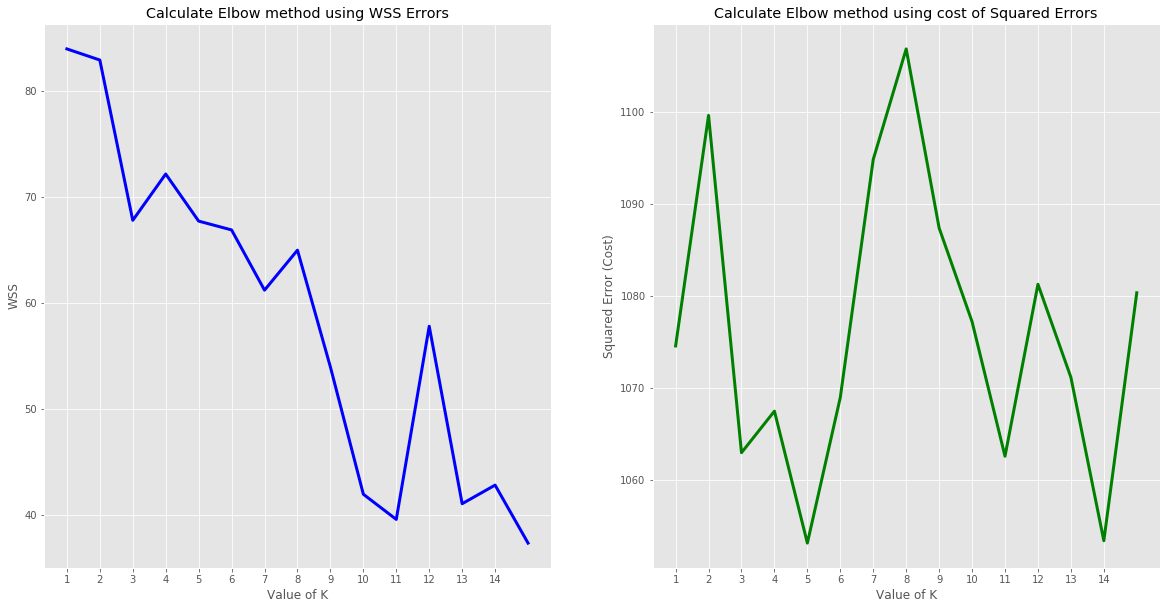

In [31]:
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

Ks = 15
sse = []

for n in range(1,Ks+1):
    x = StandardScaler().fit_transform(jakarta_gr.drop(['borough','neighborhood'],axis=1).values)
    kmeans = KMeans(n_clusters=n, init='k-means++', n_init=12).fit(x)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(x)
    curr_sse = 0

    for i in range(len(x)):
        curr_center = centroids[pred_clusters[i]]
        curr_sse += (x[i, 0] - curr_center[0]) ** 2 + (x[i, 1] - curr_center[1]) ** 2
    
    sse.append(curr_sse)

ax0.plot(range(1,Ks+1), sse, color='b', linewidth='3')
ax0.set_title('Calculate Elbow method using WSS Errors')
ax0.set_xticks(np.arange(1,Ks,1))
ax0.set_xlabel('Value of K')
ax0.set_ylabel('WSS')

# =========================================================================

cost = [] 
for i in range(1, Ks+1): 
    KM = KMeans(n_clusters=n, init='k-means++', n_init=12) 
    KM.fit(StandardScaler().fit_transform(jakarta_gr.drop(['borough','neighborhood'],axis=1).values)) 
      
    cost.append(KM.inertia_)      
  
ax1.plot(range(1, Ks+1), cost, color ='g', linewidth ='3') 
ax1.set_title('Calculate Elbow method using cost of Squared Errors')
ax1.set_xticks(np.arange(1,Ks,1))
ax1.set_xlabel("Value of K") 
ax1.set_ylabel("Squared Error (Cost)") 

plt.show()

## 5. b) Run K-Means Algorithm for clustering

In [32]:
k = 4
x = jakarta_gr.drop(['borough','neighborhood'],axis=1).values
x = StandardScaler().fit_transform(x)
km = KMeans(n_clusters=k, init='k-means++', n_init=12)
km.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## 5. c) Add cluster's label into dataset

In [33]:
jakarta_gr['cluster'] = km.labels_
jakarta_gr.groupby('cluster')['neighborhood'].count()

cluster
0    15
1     7
2    15
3     5
Name: neighborhood, dtype: int64

In [34]:
jakarta_top = jakarta_top_five.merge(jakarta_gr, on='neighborhood')
display(jakarta_top.head())

neighborhood 1st most appear category 2nd most appear category  \
0         CENGKARENG             Noodle House       Chinese Restaurant   
1  GROGOL PETAMBURAN             Noodle House       Chinese Restaurant   
2          KALIDERES             Noodle House       Chinese Restaurant   
3        KEBON JERUK             Noodle House       Chinese Restaurant   
4          KEMBANGAN       Chinese Restaurant             Noodle House   

  3rd most appear category   4th most appear category  \
0       Italian Restaurant        American Restaurant   
1       Seafood Restaurant        Japanese Restaurant   
2       Seafood Restaurant  Indonesian Meatball Place   
3       Seafood Restaurant      Indonesian Restaurant   
4       Seafood Restaurant                Pizza Place   

    5th most appear category                          borough  \
0           Sushi Restaurant  KOTA ADMINISTRASI JAKARTA BARAT   
1                 Steakhouse  KOTA ADMINISTRASI JAKARTA BARAT   
2                 Food Court  KOTA ADMINISTRASI JAKARTA BARAT   
3                Pizza Place  KOTA ADMINISTRASI JAKARTA BARAT   
4  Indonesian Meatball Place  KOTA ADMINISTRASI JAKARTA BARAT   

   Acehnese Restaurant  American Restaurant  Arepa Restaurant  ...  \
0                  0.0             0.040816               0.0  ...   
1                  0.0             0.020000               0.0  ...   
2                  0.0             0.040000               0.0  ...   
3                  0.0             0.060000               0.0  ...   
4                  0.0             0.040816               0.0  ...   

   Steakhouse  Sundanese Restaurant  Sushi Restaurant  Tapas Restaurant  \
0    0.040816              0.000000          0.040816               0.0   
1    0.040000              0.020000          0.020000               0.0   
2    0.040000              0.000000          0.020000               0.0   
3    0.020000              0.020000          0.040000               0.0   
4    0.020408              0.020408          0.020408               0.0   

   Thai Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
0         0.020408             0.00                       0.020408   
1         0.000000             0.00                       0.020000   
2         0.020000             0.02                       0.020000   
3         0.000000             0.00                       0.020000   
4         0.000000             0.00                       0.020408   

   Vietnamese Restaurant  Wine Bar  cluster  
0                    0.0       0.0        0  
1                    0.0       0.0        0  
2                    0.0       0.0        0  
3                    0.0       0.0        0  
4                    0.0       0.0        2  

[5 rows x 76 columns]

In [35]:
jr = jakarta_restaurants.rename(columns={'Neighborhood':'neighborhood'})
jakarta_top = jakarta_top.merge(jr, on='neighborhood')
display(jakarta_top.head())

neighborhood 1st most appear category 2nd most appear category  \
0   CENGKARENG             Noodle House       Chinese Restaurant   
1   CENGKARENG             Noodle House       Chinese Restaurant   
2   CENGKARENG             Noodle House       Chinese Restaurant   
3   CENGKARENG             Noodle House       Chinese Restaurant   
4   CENGKARENG             Noodle House       Chinese Restaurant   

  3rd most appear category 4th most appear category 5th most appear category  \
0       Italian Restaurant      American Restaurant         Sushi Restaurant   
1       Italian Restaurant      American Restaurant         Sushi Restaurant   
2       Italian Restaurant      American Restaurant         Sushi Restaurant   
3       Italian Restaurant      American Restaurant         Sushi Restaurant   
4       Italian Restaurant      American Restaurant         Sushi Restaurant   

                           borough  Acehnese Restaurant  American Restaurant  \
0  KOTA ADMINISTRASI JAKARTA BARAT                  0.0             0.040816   
1  KOTA ADMINISTRASI JAKARTA BARAT                  0.0             0.040816   
2  KOTA ADMINISTRASI JAKARTA BARAT                  0.0             0.040816   
3  KOTA ADMINISTRASI JAKARTA BARAT                  0.0             0.040816   
4  KOTA ADMINISTRASI JAKARTA BARAT                  0.0             0.040816   

   Arepa Restaurant  ...  Vietnamese Restaurant  Wine Bar  cluster  \
0               0.0  ...                    0.0       0.0        0   
1               0.0  ...                    0.0       0.0        0   
2               0.0  ...                    0.0       0.0        0   
3               0.0  ...                    0.0       0.0        0   
4               0.0  ...                    0.0       0.0        0   

                           Borough  Neighborhood_Latitude  \
0  KOTA ADMINISTRASI JAKARTA BARAT              -6.154879   
1  KOTA ADMINISTRASI JAKARTA BARAT              -6.154879   
2  KOTA ADMINISTRASI JAKARTA BARAT              -6.154879   
3  KOTA ADMINISTRASI JAKARTA BARAT              -6.154879   
4  KOTA ADMINISTRASI JAKARTA BARAT              -6.154879   

   Neighborhood_Longitude                   Venue  Venue_Latitude  \
0              106.737974  nasi goreng indah sari       -6.161969   
1              106.737974    Bakmi Alot Tamansari       -6.133889   
2              106.737974     Bakmi pejagalan AMI       -6.128617   
3              106.737974             Genki Sushi       -6.187277   
4              106.737974       Gandy Steak House       -6.165815   

   Venue_Longitude       Venue_Category  
0       106.738014  Javanese Restaurant  
1       106.733874         Noodle House  
2       106.754013         Noodle House  
3       106.739535     Sushi Restaurant  
4       106.763019           Steakhouse  

[5 rows x 83 columns]

In [36]:
jakarta_top.to_csv(r'Data\Jakarta_cluster.csv', index = False, header=True)

## 5. d) Visualize the resulting clusters

In [37]:
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
c_arr = mpl.cm.rainbow(np.linspace(0, 1, len(ys)))
rb = [colors.rgb2hex(i) for i in c_arr]

map_jakarta = folium.Map(location=[lat,lon], zoom_start=12)

for la, ln, nei, cat, clu in zip(jakarta_top['Venue_Latitude'],jakarta_top['Venue_Longitude'],jakarta_top['neighborhood'], jakarta_top['Venue_Category'], jakarta_top['cluster']):
    label = folium.Popup(f'{nei} (cluster {clu})', parse_html=True)
    folium.CircleMarker([la,ln], radius=5, popup=label, color=rb[clu-1], fill=True, fill_color=rb[clu-1], fill_opacity=0.7, parse_html=False).add_to(map_jakarta)

map_jakarta

---
## 6. a) Get neighborhoods' population numbers

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_jakarta = pd.read_csv('Data/Jakarta_final.csv')

jakarta_pop = df_jakarta[['borough','neighbourhoods','population(2014)']].copy()
jakarta_pop.rename(columns={'neighbourhoods':'neighborhood','population(2014)':'population'}, inplace=True)

# Normalize population with Min-Max Normalization method
jakarta_pop['norm_population'] = jakarta_pop['population'].apply(lambda x : (x-min(jakarta_pop['population']))/(max(jakarta_pop['population']) - min(jakarta_pop['population'])))

display(jakarta_pop.head())

borough   neighborhood  population  norm_population
0  KOTA ADMINISTRASI JAKARTA PUSAT  CEMPAKA PUTIH       84864         0.034403
1  KOTA ADMINISTRASI JAKARTA PUSAT         GAMBIR       78152         0.020646
2  KOTA ADMINISTRASI JAKARTA PUSAT     JOHAR BARU      117440         0.101172
3  KOTA ADMINISTRASI JAKARTA PUSAT      KEMAYORAN      220548         0.312505
4  KOTA ADMINISTRASI JAKARTA PUSAT        MENTENG       68079         0.000000

## 6. b) Calculate rank for each category using Weighted Rating (WR) formula

## $$ WR = \frac{v}{v+m}*R  +  \frac{m}{v+m}*C $$

In [3]:
jakarta_top = pd.read_csv('Data/Jakarta_cluster.csv')
jakarta_rank = jakarta_top.merge(jakarta_pop[['neighborhood','population','norm_population']], on='neighborhood')
display(jakarta_rank.head())

neighborhood 1st most appear category 2nd most appear category  \
0   CENGKARENG             Noodle House       Chinese Restaurant   
1   CENGKARENG             Noodle House       Chinese Restaurant   
2   CENGKARENG             Noodle House       Chinese Restaurant   
3   CENGKARENG             Noodle House       Chinese Restaurant   
4   CENGKARENG             Noodle House       Chinese Restaurant   

  3rd most appear category 4th most appear category 5th most appear category  \
0       Italian Restaurant      American Restaurant         Sushi Restaurant   
1       Italian Restaurant      American Restaurant         Sushi Restaurant   
2       Italian Restaurant      American Restaurant         Sushi Restaurant   
3       Italian Restaurant      American Restaurant         Sushi Restaurant   
4       Italian Restaurant      American Restaurant         Sushi Restaurant   

                           borough  Acehnese Restaurant  American Restaurant  \
0  KOTA ADMINISTRASI JAKARTA BARAT                  0.0             0.040816   
1  KOTA ADMINISTRASI JAKARTA BARAT                  0.0             0.040816   
2  KOTA ADMINISTRASI JAKARTA BARAT                  0.0             0.040816   
3  KOTA ADMINISTRASI JAKARTA BARAT                  0.0             0.040816   
4  KOTA ADMINISTRASI JAKARTA BARAT                  0.0             0.040816   

   Arepa Restaurant  ...  cluster                          Borough  \
0               0.0  ...        0  KOTA ADMINISTRASI JAKARTA BARAT   
1               0.0  ...        0  KOTA ADMINISTRASI JAKARTA BARAT   
2               0.0  ...        0  KOTA ADMINISTRASI JAKARTA BARAT   
3               0.0  ...        0  KOTA ADMINISTRASI JAKARTA BARAT   
4               0.0  ...        0  KOTA ADMINISTRASI JAKARTA BARAT   

   Neighborhood_Latitude  Neighborhood_Longitude                   Venue  \
0              -6.154879              106.737974  nasi goreng indah sari   
1              -6.154879              106.737974    Bakmi Alot Tamansari   
2              -6.154879              106.737974     Bakmi pejagalan AMI   
3              -6.154879              106.737974             Genki Sushi   
4              -6.154879              106.737974       Gandy Steak House   

   Venue_Latitude  Venue_Longitude       Venue_Category  population  \
0       -6.161969       106.738014  Javanese Restaurant      555972   
1       -6.133889       106.733874         Noodle House      555972   
2       -6.128617       106.754013         Noodle House      555972   
3       -6.187277       106.739535     Sushi Restaurant      555972   
4       -6.165815       106.763019           Steakhouse      555972   

   norm_population  
0              1.0  
1              1.0  
2              1.0  
3              1.0  
4              1.0  

[5 rows x 85 columns]

In [4]:
rest_col = ['Acehnese Restaurant', 'American Restaurant', 'Arepa Restaurant', 'Argentinian Restaurant', 'Asian Restaurant', 'Australian Restaurant', 'BBQ Joint',
       'Balinese Restaurant', 'Betawinese Restaurant', 'Bistro', 'Brazilian Restaurant', 'Buffet', 'Burger Joint', 'Burrito Place', 'Café', 'Cantonese Restaurant',
       'Chinese Restaurant', 'Coffee Shop', 'Dim Sum Restaurant', 'Diner', 'Dumpling Restaurant', 'Eastern European Restaurant', 'Fast Food Restaurant',
       'Fish & Chips Shop', 'Food Court', 'Food Truck', 'French Restaurant', 'Fried Chicken Joint', 'Grocery Store', 'Halal Restaurant', 'Hookah Bar', 'Indian Restaurant',
       'Indonesian Meatball Place', 'Indonesian Restaurant', 'Italian Restaurant', 'Japanese Restaurant', 'Javanese Restaurant', 'Kebab Restaurant', 'Korean Restaurant',
       'Lounge', 'Malay Restaurant', 'Manadonese Restaurant', 'Mexican Restaurant', 'Middle Eastern Restaurant', 'Modern European Restaurant', 'New American Restaurant',
       'Noodle House', 'Padangnese Restaurant', 'Paella Restaurant', 'Pizza Place', 'Ramen Restaurant', 'Salad Place', 'Satay Restaurant', 'Seafood Restaurant',
       'Shabu-Shabu Restaurant', 'Snack Place', 'Soba Restaurant', 'Soup Place', 'Spanish Restaurant', 'Steakhouse', 'Sundanese Restaurant', 'Sushi Restaurant',
       'Tapas Restaurant', 'Thai Restaurant', 'Udon Restaurant', 'Vegetarian / Vegan Restaurant', 'Vietnamese Restaurant', 'Wine Bar']

df_WR = jakarta_rank[['borough','neighborhood']]

for i in rest_col:
    df_WR[i+'_WR'] = [ (jakarta_rank.loc[n,'population']/(jakarta_rank.loc[n,'population'] + jakarta_rank['population'].quantile(0.90)))*jakarta_rank.loc[n,i] + (jakarta_rank['population'].quantile(0.90)/(jakarta_rank.loc[n,'population'] + jakarta_rank['population'].quantile(0.90)))*(sum(jakarta_rank[i])/len(jakarta_rank)) for n in range(len(jakarta_rank)) ]

df_WR = df_WR.replace(np.nan,0.0)
df_WR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2048
Data columns (total 70 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   borough                           2049 non-null   object 
 1   neighborhood                      2049 non-null   object 
 2   Acehnese Restaurant_WR            2049 non-null   float64
 3   American Restaurant_WR            2049 non-null   float64
 4   Arepa Restaurant_WR               2049 non-null   float64
 5   Argentinian Restaurant_WR         2049 non-null   float64
 6   Asian Restaurant_WR               2049 non-null   float64
 7   Australian Restaurant_WR          2049 non-null   float64
 8   BBQ Joint_WR                      2049 non-null   float64
 9   Balinese Restaurant_WR            2049 non-null   float64
 10  Betawinese Restaurant_WR          2049 non-null   float64
 11  Bistro_WR                         2049 non-null   float64
 12  Brazil

## 6. c) Sort by Weighted Rating's value to get recommend category for each neighborhood

In [5]:
a = df_WR.groupby('neighborhood').mean().reset_index()
jakarta_recommend = pd.DataFrame({})

for i in range(len(a['neighborhood'])):
    jakarta_recommend.loc[i,'neighborhood'] = a['neighborhood'][i]
    st,nd,rd,th,s,n,r,t = 0,0,0,0,'','','',''
    for v,c in zip(a[a['neighborhood'] == a['neighborhood'][i]].drop('neighborhood',axis=1).values[0], a[a['neighborhood'] == a['neighborhood'][i]].drop('neighborhood',axis=1).columns):
        if v > th:
            if v > rd:
                if v > nd:
                    if v > st:
                        st = v
                    else:
                        nd,jakarta_recommend.loc[i,'1st recommended category'] = v,c.split('_')[0]
                else:
                    rd,jakarta_recommend.loc[i,'2nd recommended category'] = v,c.split('_')[0]
            else:
                th,jakarta_recommend.loc[i,'3rd recommended category'] = v,c.split('_')[0]

## 6. d) THE RESULT DATASET for RECOMMEND FOOD & BEVERAGE CATEGORIES

In [6]:
display(jakarta_recommend)

neighborhood   1st recommended category 2nd recommended category  \
0              CAKUNG                Pizza Place      Japanese Restaurant   
1       CEMPAKA PUTIH                Pizza Place       Seafood Restaurant   
2          CENGKARENG                 Steakhouse              Pizza Place   
3            CILANDAK         Seafood Restaurant               Steakhouse   
4           CILINCING         Seafood Restaurant      Japanese Restaurant   
5            CIPAYUNG         Seafood Restaurant         Sushi Restaurant   
6             CIRACAS                Pizza Place       Seafood Restaurant   
7         DUREN SAWIT         Seafood Restaurant               Steakhouse   
8              GAMBIR                Pizza Place               Steakhouse   
9   GROGOL PETAMBURAN         Seafood Restaurant              Pizza Place   
10          JAGAKARSA         Seafood Restaurant              Pizza Place   
11         JATINEGARA  Indonesian Meatball Place    Padangnese Restaurant   
12         JOHAR BARU                Pizza Place       Seafood Restaurant   
13          KALIDERES         Seafood Restaurant               Steakhouse   
14     KEBAYORAN BARU        Japanese Restaurant              Pizza Place   
15     KEBAYORAN LAMA        Japanese Restaurant              Pizza Place   
16        KEBON JERUK         Seafood Restaurant    Indonesian Restaurant   
17      KELAPA GADING                Pizza Place               Steakhouse   
18          KEMAYORAN                Pizza Place       Seafood Restaurant   
19          KEMBANGAN         Seafood Restaurant      Japanese Restaurant   
20               KOJA         Seafood Restaurant              Pizza Place   
21        KRAMAT JATI                Pizza Place               Steakhouse   
22            MAKASAR         Seafood Restaurant               Steakhouse   
23   MAMPANG PRAPATAN        Japanese Restaurant              Pizza Place   
24           MATRAMAN      Padangnese Restaurant              Pizza Place   
25            MENTENG                Pizza Place       Seafood Restaurant   
26         PADEMANGAN                Pizza Place       Seafood Restaurant   
27           PALMERAH                 Steakhouse       Seafood Restaurant   
28           PANCORAN                Pizza Place      Japanese Restaurant   
29       PASAR MINGGU                Pizza Place               Steakhouse   
30         PASAR REBO                Pizza Place               Steakhouse   
31        PENJARINGAN         Seafood Restaurant              Pizza Place   
32       PESANGGRAHAN                Pizza Place       Seafood Restaurant   
33        PULO GADUNG                Pizza Place               Steakhouse   
34        SAWAH BESAR                Pizza Place       Seafood Restaurant   
35              SENEN                Pizza Place       Seafood Restaurant   
36          SETIABUDI        Japanese Restaurant              Pizza Place   
37         TAMAN SARI                Pizza Place               Steakhouse   
38            TAMBORA         Seafood Restaurant               Steakhouse   
39        TANAH ABANG        Japanese Restaurant              Pizza Place   
40      TANJUNG PRIOK                Pizza Place       Seafood Restaurant   
41              TEBET                Pizza Place               Steakhouse   

         3rd recommended category  
0              Seafood Restaurant  
1                      Steakhouse  
2                Sushi Restaurant  
3                Sushi Restaurant  
4                      Steakhouse  
5   Vegetarian / Vegan Restaurant  
6                      Steakhouse  
7           Padangnese Restaurant  
8                Sushi Restaurant  
9                      Steakhouse  
10                     Steakhouse  
11                    Pizza Place  
12                     Steakhouse  
13          Padangnese Restaurant  
14                     Steakhouse  
15                     Steakhouse  
16            Japanese Restaurant  
17  Vegetarian / Vegan Restaurant  
18           

### Here the model will recommend top 3 of food & beverage category for each neighborhood if you wanna open new restaurant in Jakarta's area for specific district.
## Thank you!